In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

sys.path.append(os.path.abspath('..'))
import lib

# Semantic cutoff

## data

In [3]:
dataset_main = lib.data.Datasets.Main()
df_test = dataset_main.queries
df_tool_embeddings = dataset_main.tool_embeddings
df_tool_descriptions = dataset_main.tool_descriptions

SOURCE = None
SOURCE = 'ToolE'
# SOURCE = 'Berkeley'
# SOURCE = 'ToolLens'

if SOURCE is not None:
    df_test = df_test[df_test['source'] == SOURCE].reset_index(drop=True)
    df_tool_descriptions = df_tool_descriptions[df_tool_descriptions['source'] == SOURCE].reset_index(drop=True)
    df_tool_embeddings = df_tool_embeddings[df_tool_embeddings['tool'].isin(df_tool_descriptions['tool'])].reset_index(drop=True)

In [4]:
df_embeddings = df_tool_embeddings.copy()
tools: np.ndarray = df_embeddings['tool'].values
embeddings: np.ndarray = np.vstack(df_embeddings['embedding'].values)

# Compute pairwise cosine similarity
similarity_matrix = cosine_similarity(embeddings)

# Set threshold
threshold = 0.8

# Find similar tools above threshold
similar_tools = []
best_sim = []
for i, tool in enumerate(tools):
    sims = similarity_matrix[i]
    # Exclude self-match
    similar_indices = np.where((sims >= threshold) & (np.arange(len(sims)) != i))[0]
    # Sort by similarity (descending)
    sorted_similar = sorted(
        [(tools[j], sims[j]) for j in similar_indices],
        key=lambda x: -x[1]
    )
    similar_tools.append([f"{name} ({score:.3f})" for name, score in sorted_similar])
    best_sim.append(sorted_similar[0][1] if sorted_similar else None)

# Save to DataFrame
df_embeddings['similar_tools'] = similar_tools
df_embeddings['best_sim'] = best_sim

# Sort by best similarity
df_embeddings = df_embeddings.sort_values(by='best_sim', ascending=False)
df_embeddings

,tool,embedding,similar_tools,best_sim
188,tool_e.house_purchasing_tool,"[-0.02950206771492958, 0.017958972603082657, 0...","[tool_e.house_renting_tool (0.938), tool_e.res...",0.938006
187,tool_e.house_renting_tool,"[-0.0200491975992918, 0.012352228164672852, 0....","[tool_e.house_purchasing_tool (0.938), tool_e....",0.938006
17,tool_e.mixer_box__translate__a_i_language_tutor,"[-0.012427120469510555, -0.004374954849481583,...","[tool_e.speak (0.922), tool_e.robo_ad (0.845),...",0.922135
150,tool_e.speak,"[-0.013421496376395226, -0.0040044886991381645...",[tool_e.mixer_box__translate__a_i_language_tut...,0.922135
166,tool_e.n_a_s_a_tool,"[-0.0030527880880981684, -0.002989086089655757...","[tool_e.stellarexplorer (0.918), tool_e.social...",0.917855
...,...,...,...,...
129,tool_e.indoor_plants,"[0.02163904905319214, 0.0001625489821890369, 0...",[],NaN
145,tool_e.tax__calculator,"[0.01343420147895813, -0.016217747703194618, 0...",[],NaN
147,tool_e.a_i2sql,"[0.00043295728391967714, 0.03407277166843414, ...",[],NaN
148,tool_e.haulingbuddies,"[0.013872655108571053, -0.018802162259817123, ...",[],NaN


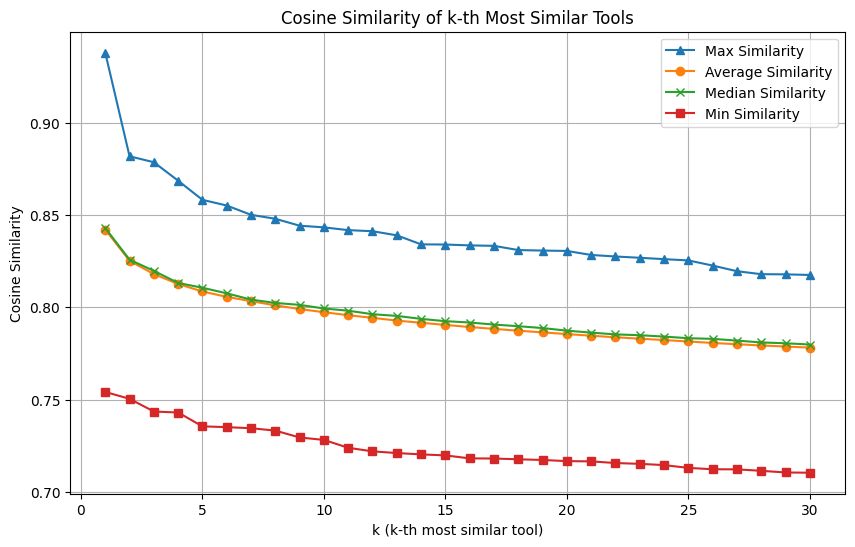

At k=20:
  Avg Similarity: 0.7855
  Min Similarity: 0.7167
  Max Similarity: 0.8306


In [5]:
# Assuming df has 'tool' and 'embedding' columns
# Convert embeddings to a matrix (assuming each embedding is a list/array)
embeddings = np.stack(df_embeddings['embedding'].values)

# Compute pairwise cosine similarities
similarity_matrix = cosine_similarity(embeddings)

# Set diagonal to -inf to exclude self-matches
np.fill_diagonal(similarity_matrix, -np.inf)

# Sort similarities for each row (tool), descending order
sorted_similarities = np.sort(similarity_matrix, axis=1)[:, ::-1]  # sort descending

# Store average, min, and max similarity at each k (1-indexed)
k_range = range(1, 31)
avg_similarities = []
min_similarities = []
max_similarities = []
median_similarities = []

for k in k_range:
    kth_similarities = sorted_similarities[:, k-1]  # k-1 because of 0 indexing
    avg_similarities.append(np.mean(kth_similarities))
    min_similarities.append(np.min(kth_similarities))
    max_similarities.append(np.max(kth_similarities))
    median_similarities.append(np.median(kth_similarities))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(k_range, max_similarities, label='Max Similarity', marker='^')
plt.plot(k_range, avg_similarities, label='Average Similarity', marker='o')
plt.plot(k_range, median_similarities, label='Median Similarity', marker='x')
plt.plot(k_range, min_similarities, label='Min Similarity', marker='s')
plt.xlabel('k (k-th most similar tool)')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity of k-th Most Similar Tools')
plt.legend()
plt.grid(True)
plt.show()

# Show stats at k=20
k = 20
print(f"At k={k}:")
print(f"  Avg Similarity: {avg_similarities[k-1]:.4f}")
print(f"  Min Similarity: {min_similarities[k-1]:.4f}")
print(f"  Max Similarity: {max_similarities[k-1]:.4f}")

# save as pdf
# plt.savefig('semantic_cutoff.pdf', bbox_inches='tight')

Smaller plot

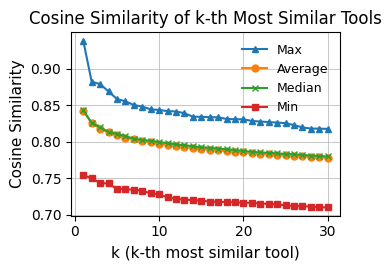

In [6]:
# Plotting with single-column adjustments
plt.figure(figsize=(3.6, 2.8))  # ~9 cm wide, good for single column
plt.plot(k_range, max_similarities, label='Max', marker='^', linewidth=1.5, markersize=5)
plt.plot(k_range, avg_similarities, label='Average', marker='o', linewidth=1.5, markersize=5)
plt.plot(k_range, median_similarities, label='Median', marker='x', linewidth=1.5, markersize=5)
plt.plot(k_range, min_similarities, label='Min', marker='s', linewidth=1.5, markersize=5)

plt.xlabel('k (k-th most similar tool)', fontsize=11)
plt.ylabel('Cosine Similarity', fontsize=11)
plt.title('Cosine Similarity of k-th Most Similar Tools', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=9, frameon=False)
plt.grid(True, linewidth=0.5)

plt.tight_layout()
plt.savefig('results/semantic_cutoff.pdf', bbox_inches='tight')
plt.show()

# Testing multitool task on ToolE

## Experiment

### Experiments setup

In [7]:
# import basemodel
from pydantic import BaseModel, Field, ConfigDict

class ExperimentSetup(BaseModel):
    model_config = ConfigDict(
        arbitrary_types_allowed=True
    )
    title: str
    color: str
    true_tool_max_sim: float = None
    true_tool_skip_n: int = None
    results: pd.DataFrame = Field(default_factory=pd.DataFrame)
    results_log: pd.DataFrame = Field(default_factory=pd.DataFrame)
    metrics: dict = Field(default_factory=dict)

experiments: list[ExperimentSetup] = [
    ExperimentSetup(
        title="No cutoff",
        color="red",
    ),
    ExperimentSetup(
        title="Without top 20",
        color="blue",
        true_tool_skip_n=20
    ),
    ExperimentSetup(
        title="Without top 10",
        color="green",
        true_tool_skip_n=10
    ),
    ExperimentSetup(
        title="Max sim 0.75",
        color="orange",
        true_tool_max_sim=0.75
    ),
    ExperimentSetup(
        title="Max sim 0.8",
        color="purple",
        true_tool_max_sim=0.8
    ),
    ExperimentSetup(
        title="Max sim 0.85",
        color="brown",
        true_tool_max_sim=0.85,
    ),
]


### Agent setup

In [8]:
# Number of samples for each task
NUM_SAMPLES = 2000

# Set random seed for reproducibility
random_state = 0

SOURCE = None
SOURCE = 'ToolE'
# SOURCE = 'Berkeley'
# SOURCE = 'ToolLens'

### OpenAI
# https://platform.openai.com/docs/models
CLIENT_TYPE = lib.agent.ClientType.OPENAI
MODEL_NAME = 'gpt-4o-mini'
# MODEL_NAME = 'gpt-3.5-turbo'
SETUPTYPE = lib.experiment.ExperimentSetupType.REACT_SINGLE_STEP

(
    react_agent, 
    df_test_single, 
    df_test_multi, 
    df_tool_descriptions, 
    df_tool_embeddings, 
    prompt_single, 
    prompt_multi, 
    experiment_name, 
    plot_title, 
    description
) = lib.experiment.load_experiment_setup(
    SETUPTYPE,
    CLIENT_TYPE,
    MODEL_NAME,
    SOURCE,
    NUM_SAMPLES,
    random_state=random_state,
)

Data source: ToolE, 2000 single tool samples, 497 multi tool samples.
Initializing single-step ReAct agent...
Experiment setup: ReAct (ReAct (one step))
	Model: gpt-4o-mini
	Temperature: 0
	Max Turns: 15
	Top-K Tools: 10
	Similarity Threshold: 0.8
	Action Queue: False
	Co-occurrence: False


### Run experiments

In [9]:
for experiment in experiments:
    react_agent.tool_retriever.true_tool_max_sim = experiment.true_tool_max_sim
    react_agent.tool_retriever.true_tool_skip_n = experiment.true_tool_skip_n

    # Run the agent on each task
    multi, multi_log = await lib.experiment.run_experiment(react_agent, df_test_multi, prompt=prompt_multi, description=experiment.title, concurrency_limit=64)
    experiment.results = multi
    experiment.results_log = multi_log

    # Compute metrics for each task
    multi_metrics = lib.data.compute_action_metrics(multi, filter_ground_truth=False, max_turns=react_agent.max_turns)
    experiment.metrics = multi_metrics

Max sim 0.85: 100%|██████████| 497/497 [01:01<00:00,  8.07it/s, TP=180, FP=291, FN=26, TN=0, Accuracy=0.362, Precision=0.382, Recall=0.874, F1=0.532, Specificity=None, TCA=0.533, CR=0.362, OR=0.814, AUT=0.806, Retr. Rec.=0.849, Avg. Retr. %=0.923, Avg. turns Left / max turns=1, _Avg. turns used=0, _Avg. OR=0.205, _Avg. AUT=0.215, _Avg. tokens=3.43e+3, _Avg. llm calls=1, _n=497]


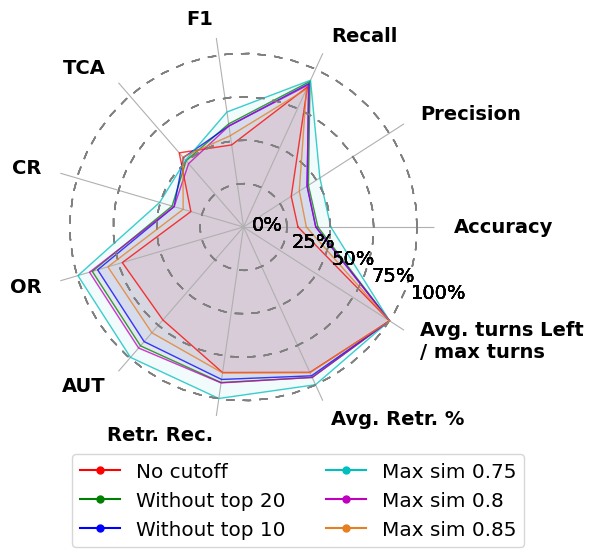

In [ ]:
import matplotlib.lines as mlines

fig, axes = plt.subplots(1, 1, figsize=(6, 6), subplot_kw=dict(polar=True))
axes: plt.Axes = axes  # Flatten the 2D array of axes for easy iteration
handles: dict[str, mlines.Line2D] = {}

for (metric, legend_label, color) in zip(
    [experiment.metrics for experiment in experiments],
    [experiment.title for experiment in experiments],
    ['r', 'g', 'b', 'c', 'm', '#E67E22']
):
    # Plot each metric on the corresponding axis
    lib.data.plot_metrics_radar(metric, None, ax=axes, backgroundcolor=color)
    handles[legend_label] = mlines.Line2D([], [], color=color, marker='o', markersize=5, label=legend_label)

# Get timestamp
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

lgd = fig.legend(
    handles=handles.values(),
    loc='lower center', bbox_to_anchor=(0.5, -0.05),
    # loc='upper center', bbox_to_anchor=(0.5,-0.1),
    fontsize='x-large',
    # ncol=len(handles),
    ncol=2,
    bbox_transform=fig.transFigure
)

plt.tight_layout()
# plt.savefig(f'react_multi_cutoffs.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()